# JQA Co-Ref Time Elapsed

In [75]:
import re, json, itertools, datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from networkx.algorithms import community
from networkx.readwrite import json_graph
from json import JSONEncoder
from operator import itemgetter
from collections import Counter
    
# Declare directory location to shorten filepaths later.
abs_dir = "/Users/quinn.wi/Documents/Data/"

In [88]:
%%time

df = pd.read_csv(abs_dir + 'Output/ParsedXML/JQA_dataframe.txt',
                 sep = '\t')[['entry', 'people', 'date']] \
    .dropna()

# links must have timestamp (unixepoch)
df['year'] = df['date'].astype(str) + '-01-01'
df['year'] = pd.to_datetime(df['year'])
df['unix'] = df['year'].apply(lambda x: datetime.datetime.timestamp(x) * 1000)

# Split string of people into individuals.
df['people'] = df['people'].str.split(r',|;')

# Pair individuals in co-occurence list.
df['coOccur'] = df.apply(lambda row: list(itertools.combinations(row['people'], 2)), axis = 1)

df = df.explode('coOccur')

df[['source', 'target']] = pd.DataFrame(df['coOccur'].tolist(), index = df.index)

df = df.drop(columns = ['people', 'coOccur'])

# Count instances of pairs for each year.
df = df.groupby(['unix', 'source', 'target'])['unix'].agg('count').to_frame('weight').reset_index()

df

CPU times: user 602 ms, sys: 21.3 ms, total: 623 ms
Wall time: 626 ms


,unix,source,target,weight
0,-4.701967e+12,adams-george,adams-john2,1
1,-4.701967e+12,adams-george,baring-francis,1
2,-4.701967e+12,adams-george,beecher-philemon,1
3,-4.701967e+12,adams-george,cushman-joshua,1
4,-4.701967e+12,adams-george,dana-samuel,1
...,...,...,...,...
247328,-4.544287e+12,smith-william-steuben,randall-thomas,1
247329,-4.544287e+12,smith-william-steuben,smith-catherine-johnson,1
247330,-4.544287e+12,smith-william-steuben,sullivan-george,1
247331,-4.544287e+12,sullivan-george,huntt-henry,1


CPU times: user 21.9 ms, sys: 1.55 ms, total: 23.5 ms
Wall time: 22.2 ms


(array([2.46466e+05, 0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00,
        8.61000e+02, 0.00000e+00, 0.00000e+00, 0.00000e+00, 6.00000e+00]),
 array([1. , 1.2, 1.4, 1.6, 1.8, 2. , 2.2, 2.4, 2.6, 2.8, 3. ]),
 <a list of 10 Patch objects>)

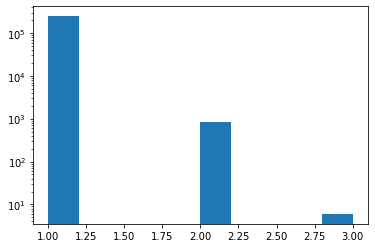

In [82]:
%%time

plt.hist(df['weight'], log = True)

## Network

In [96]:
%%time

# Initialize graph object.
G = nx.from_pandas_edgelist(df, 'source', 'target', ['weight', 'unix'])

# Add nodes.
nodes = list( dict.fromkeys( df['source'].values.tolist() + df['target'].values.tolist()))
nodes = pd.DataFrame( nodes, columns = ['source'])

G.add_nodes_from(nodes)
print (nx.info(G))

Name: 
Type: Graph
Number of nodes: 5136
Number of edges: 177421
Average degree:  69.0892
CPU times: user 671 ms, sys: 9.13 ms, total: 680 ms
Wall time: 686 ms


In [97]:
%%time

# Set degree attributes.
nx.set_node_attributes(G, dict(G.degree(G.nodes())), 'degree')

# Sort nodes by degree and print top results.
sorted_degree = sorted(dict(G.degree(G.nodes())).items(),
                       key = itemgetter(1), reverse = True)

print ("Top 10 nodes by degree:")
for d in sorted_degree[:10]:
    print (f'\t{d[0]}, {d[1]}')

# Measure network density.
density = nx.density(G)
print (f"Network density: {density:.3f}")

# Related to diameter, check if network is connected and, therefore, can have a diameter.
print (f"Is the network connected? {nx.is_connected(G)}")

# Get a list of network components (communities).
# Find the largest component.
components = nx.connected_components(G)
largest_component = max(components, key = len)

# Create a subgraph of the largest component and measure its diameter.
subgraph = G.subgraph(largest_component)
diameter = nx.diameter(subgraph)
print (f"Network diameter of the largest component: {diameter:.3f}")

# Find triadic closure (similar to density).
triadic_closure = nx.transitivity(G)
print (f"Triadic closure: {triadic_closure:.3f}\n")

# Find centrality measures.
betweenness_dict = nx.betweenness_centrality(G) # Run betweenness centrality
eigenvector_dict = nx.eigenvector_centrality(G) # Run eigenvector centrality
degree_cent_dict = nx.degree_centrality(G)

# Assign each centrality measure to an attribute.
nx.set_node_attributes(G, betweenness_dict, 'betweenness')
nx.set_node_attributes(G, eigenvector_dict, 'eigenvector')
nx.set_node_attributes(G, degree_cent_dict, 'degree_cent')

Top 10 nodes by degree:
	calhoun-john, 2204
	southard-samuel, 1896
	adams-george, 1761
	brent-daniel, 1558
	jackson-andrew, 1489
	wyer-edward, 1476
	adams-john2, 1431
	wirt-william, 1366
	hay-george, 1306
	barbour-james, 1300
Network density: 0.013
Is the network connected? False
Network diameter of the largest component: 5.000
Triadic closure: 0.202

CPU times: user 18min 12s, sys: 4.19 s, total: 18min 16s
Wall time: 18min 27s


In [98]:
%%time

data = json_graph.node_link_data(G)

with open(abs_dir + '../GitHub/dsg-mhs/lab_space/projects/jqa/network/data/jqa-network-time.json', 'w', encoding = 'utf-8') as f:
    json.dump(data, f, indent = 4)

CPU times: user 1.4 s, sys: 54.9 ms, total: 1.45 s
Wall time: 1.47 s
